In [1]:
#Full Code: 20 Questions Game with REINFORCE + Masking + Plot

In [3]:
#!pip install torch

Episode 0, Success Rate: 30.00%
Episode 100, Success Rate: 40.00%
Episode 200, Success Rate: 20.00%
Episode 300, Success Rate: 35.00%
Episode 400, Success Rate: 25.00%
Episode 500, Success Rate: 35.00%
Episode 600, Success Rate: 30.00%
Episode 700, Success Rate: 35.00%
Episode 800, Success Rate: 35.00%
Episode 900, Success Rate: 50.00%
Episode 1000, Success Rate: 25.00%
Episode 1100, Success Rate: 30.00%
Episode 1200, Success Rate: 40.00%
Episode 1300, Success Rate: 35.00%
Episode 1400, Success Rate: 40.00%
Episode 1500, Success Rate: 30.00%
Episode 1600, Success Rate: 20.00%
Episode 1700, Success Rate: 20.00%
Episode 1800, Success Rate: 20.00%
Episode 1900, Success Rate: 35.00%
Episode 2000, Success Rate: 30.00%
Episode 2100, Success Rate: 25.00%
Episode 2200, Success Rate: 15.00%
Episode 2300, Success Rate: 10.00%
Episode 2400, Success Rate: 30.00%
Episode 2500, Success Rate: 40.00%
Episode 2600, Success Rate: 40.00%
Episode 2700, Success Rate: 40.00%
Episode 2800, Success Rate: 25.0

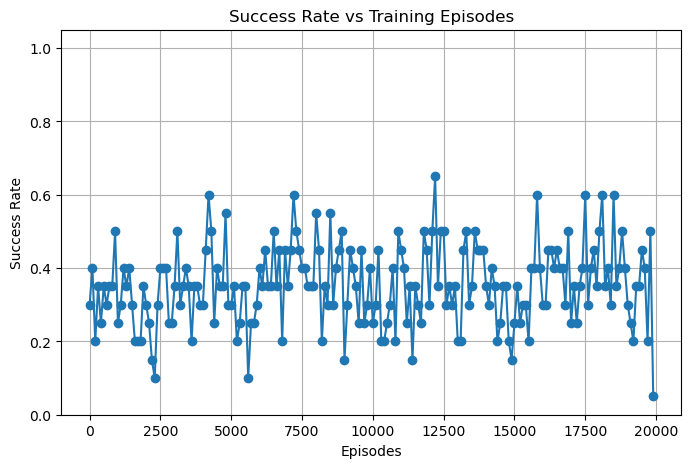


Starting a new 20 Questions Game!
Target Animal: sole
Let's start asking questions...

Q1: Does the animal have 'Predator'? -> No
Q2: Does the animal have 'Catsize'? -> No
Q3: Does the animal have 'Hair'? -> No
Q4: Does the animal have 'Mammal'? -> No
Q5: Does the animal have 'Breathes'? -> No
Q6: Does the animal have 'Domestic'? -> No
Q7: Does the animal have 'Nlegs_4'? -> No
Q8: Does the animal have 'Insect'? -> No
Q9: Does the animal have 'Tail'? -> Yes
Q10: Does the animal have 'Fins'? -> Yes
Q11: Does the animal have 'Nlegs_0'? -> Yes
Q12: Does the animal have 'Aquatic'? -> Yes
Q13: Does the animal have 'Backbone'? -> Yes
Q14: Does the animal have 'Nlegs_5'? -> No
Q15: Does the animal have 'Venomous'? -> No
Q16: Does the animal have 'Amphibian'? -> No
Q17: Does the animal have 'Airborne'? -> No
Q18: Does the animal have 'Reptile'? -> No
Q19: Does the animal have 'Bird'? -> No
Q20: Does the animal have 'Nlegs_8'? -> No

Could not guess the animal with certainty.
Success: False

Ev

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel('knowledge_base1.xlsx')

FEATURES = ["Hair", "Feathers", "Eggs", "Milk", "Airborne", "Aquatic", "Predator", "Toothed",
            "Backbone", "Breathes", "Venomous", "Fins", "Nlegs_0", "Nlegs_2", "Nlegs_4",
            "Nlegs_5", "Nlegs_6", "Nlegs_8", "Tail", "Domestic", "Catsize",
            "Mammal", "Bird", "Reptile", "Fish", "Amphibian", "Insect", "Invertebrate"]

NUM_ANIMALS = 100  
NUM_FEATURES = len(FEATURES)
MAX_STEPS = 20

animal_features = df.iloc[:, 1:].values  # Excluding the animal names

class AnimalQuestionEnv:
    def __init__(self):
        self.animals = list(range(NUM_ANIMALS))
        self.target_animal = random.choice(self.animals)
        self.remaining_animals = set(self.animals)
        self.state = np.ones(NUM_FEATURES)
        self.step_count = 0
        self.done = False
        self.asked_features = set()

    def reset(self):
        self.target_animal = random.choice(self.animals)
        self.remaining_animals = set(self.animals)
        self.state = np.ones(NUM_FEATURES)
        self.step_count = 0
        self.done = False
        self.asked_features = set()
        return self.state

    def step(self, action):
        if self.done:#If the game has already ended, stop processing — return state, 0 reward, and done = True.
            return self.state, 0, self.done
    
        feature_idx = int(action.item())#Converts the PyTorch tensor action to an integer: action = tensor(3)  # "Milk"
        feature_idx = max(0, min(NUM_FEATURES - 1, feature_idx))#Ensures the index is within valid bounds (0 to NUM_FEATURES-1): feature_idx = 3
    
        correct_answer = animal_features[self.target_animal][feature_idx]#correct_answer is either 0 or 1, depending on whether the target animal has the feature.
    
        previous_remaining = len(self.remaining_animals)  # Save the number of animals still possible(to update next stages)
    
        #Filter remaining animals based on the feature answer: Keep animals whose feature value (0 or 1) matches the target animal’s value for that same feature.
        self.remaining_animals = {
            a for a in self.remaining_animals if animal_features[a][feature_idx] == correct_answer
        }
        #✅Example) Suppose we had 40 animals remaining, After asking "Milk?" The target animal is a bird, and we get "No"
        #All animals that answer “Yes” to this feature are eliminated: maybe 15 animals are eliminated 
        # The new candidate pool has 25 animals
        #✅Actually we are keeping only those animals where: animal_features[a][feature_idx] == correct_answer
        #So if the target animal’s feature value is 0 for a given feature, it keeps only animals that also have 0 for that feature.
    
        # Update state
        self.state[feature_idx] = correct_answer #Marks in the state vector that this feature has been asked and its answer known
        self.step_count += 1 #Increments step count
    
        # Calculate how many animals were eliminated
        eliminated = previous_remaining - len(self.remaining_animals)#Compute how many animals were eliminated
    
        # Reward based on elimination
        reward = eliminated 
        #✅This means the agent gets rewarded for asking useful questions(that eliminate many wrong candidates from possible animals).
        #✅In this game: 
        #1)The goal is to identify the target animal. 
        #2)Each question should help narrow the search space, 
        #3)So, a "good" question is one that eliminates as many wrong animals as possible
        #✅Suppose 40 animals remain
        #Agent asks: “Does it lay eggs?”
        #20 animals are eliminated → reward = 20
        #Agent learns that this question was very useful in that situation
        #✅ Why This Works Well
        #Encourages efficient, discriminative questioning
        #Speeds up convergence to the correct animal
        
    
        # Bonus reward if eliminated a large number
        if eliminated >= 10:  # Adjust threshold based on dataset
            reward += 10
    
        # Penalty for repeated questions
        if feature_idx in self.asked_features:
            reward -= 5
        else:
            self.asked_features.add(feature_idx)
    
        # Done conditions
        if self.step_count >= MAX_STEPS or len(self.remaining_animals) == 1:
            self.done = True
            guessed_animal = next(iter(self.remaining_animals), -1)
            reward = 30 if guessed_animal == self.target_animal else -30
    
        return self.state, reward, self.done

# Policy Network
class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(NUM_FEATURES, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, NUM_FEATURES)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return torch.softmax(self.output_layer(x), dim=-1)

# Training loop
env = AnimalQuestionEnv()
policy_net = PolicyNetwork()
optimizer = optim.Adam(policy_net.parameters(), lr=0.001)

gamma = 0.99
num_episodes = 20000
success_rates = []
episodes = []

for episode in range(num_episodes):
    state = env.reset()
    log_probs = []
    rewards = []

    for t in range(MAX_STEPS):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action_probs = policy_net(state_tensor).squeeze(0).clone()

        # Mask already asked features
        for f in env.asked_features:
            action_probs[f] = 0

        if action_probs.sum() == 0:
            break

        action_probs = action_probs / action_probs.sum()
        action_dist = torch.distributions.Categorical(action_probs)
        action = action_dist.sample()

        log_prob = action_dist.log_prob(action)
        log_probs.append(log_prob)

        next_state, reward, done = env.step(action)
        rewards.append(reward)

        if done:
            break
        state = next_state

    # Compute discounted returns
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)

    returns = torch.tensor(returns, dtype=torch.float32)
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)

    # Policy Loss
    policy_loss = []
    for log_prob, R in zip(log_probs, returns):
        policy_loss.append(-log_prob * R)

    optimizer.zero_grad()
    sum(policy_loss).backward()
    optimizer.step()

    # Record success every 100 episodes
    if episode % 100 == 0:
        successes = 0
        eval_games = 20
        for _ in range(eval_games):
            test_env = AnimalQuestionEnv()
            state = test_env.reset()

            for _ in range(MAX_STEPS):
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                with torch.no_grad():
                    action_probs = policy_net(state_tensor).squeeze(0).clone()

                for f in test_env.asked_features:
                    action_probs[f] = 0

                if action_probs.sum() == 0:
                    break

                action_probs = action_probs / action_probs.sum()
                action_dist = torch.distributions.Categorical(action_probs)
                action = action_dist.sample()

                next_state, reward, done = test_env.step(action)
                if done:
                    break
                state = next_state

            if len(test_env.remaining_animals) == 1:
                guessed_animal_idx = next(iter(test_env.remaining_animals))
                if guessed_animal_idx == test_env.target_animal:
                    successes += 1

        success_rate = successes / eval_games
        success_rates.append(success_rate)
        episodes.append(episode)

        print(f"Episode {episode}, Success Rate: {success_rate*100:.2f}%")

print("Training complete!")

#Plot Success Rate
plt.figure(figsize=(8,5))
plt.plot(episodes, success_rates, marker='o')
plt.title('Success Rate vs Training Episodes')
plt.xlabel('Episodes')
plt.ylabel('Success Rate')
plt.grid(True)
plt.ylim(0, 1.05)
plt.show()

#Play a Full Game
def play_game(env, policy_net):
    state = env.reset()

    print("\nStarting a new 20 Questions Game!")
    print(f"Target Animal: {df.iloc[env.target_animal, 0]}")
    print("Let's start asking questions...\n")

    for step in range(MAX_STEPS):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            action_probs = policy_net(state_tensor).squeeze(0).clone()

        for f in env.asked_features:
            action_probs[f] = 0

        if action_probs.sum() == 0:
            break

        action_probs = action_probs / action_probs.sum()
        action_dist = torch.distributions.Categorical(action_probs)
        action = action_dist.sample()

        feature_idx = int(action.item())
        feature_name = FEATURES[feature_idx]

        correct_answer = animal_features[env.target_animal][feature_idx]
        answer_text = "Yes" if correct_answer == 1 else "No"

        print(f"Q{step+1}: Does the animal have '{feature_name}'? -> {answer_text}")

        next_state, reward, done = env.step(action)

        if done:
            break
        state = next_state

    if len(env.remaining_animals) == 1:
        guessed_animal_idx = next(iter(env.remaining_animals))
        guessed_animal_name = df.iloc[guessed_animal_idx, 0]
        print(f"\nFinal Guess: {guessed_animal_name}")
    else:
        guessed_animal_name = "Unknown"
        print("\nCould not guess the animal with certainty.")

    success = guessed_animal_name == df.iloc[env.target_animal, 0]
    print(f"Success: {success}")

play_game(env, policy_net)

# Evaluate over 500 games
def evaluate_agent(env, policy_net, num_games=100):
    total_successes = 0
    total_steps = 0

    for game in range(num_games):
        state = env.reset()
        
        for step in range(MAX_STEPS):
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                action_probs = policy_net(state_tensor).squeeze(0).clone()

            for f in env.asked_features:
                action_probs[f] = 0

            if action_probs.sum() == 0:
                break

            action_probs = action_probs / action_probs.sum()
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()

            next_state, reward, done = env.step(action)
            if done:
                break
            state = next_state

        if len(env.remaining_animals) == 1:
            guessed_animal_idx = next(iter(env.remaining_animals))
            if guessed_animal_idx == env.target_animal:
                total_successes += 1

        total_steps += (step + 1)

    avg_success_rate = total_successes / num_games
    avg_steps = total_steps / num_games

    print("\nEvaluation Results")
    print(f"Number of games: {num_games}")
    print(f"Success Rate: {avg_success_rate * 100:.2f}%")
    print(f"Average Steps per Game: {avg_steps:.2f}")

# Run evaluation
evaluate_agent(env, policy_net, num_games=150)